# Introduction

## Dataset Overview

Deeds (Digital Electronic Education and Design Suite) (Ponta et al., 1998) is a simulation environment for e-learning in digital electronics. The environment provides learning materials through specialized browsers for the students, and asks them to solve various problems with different levels of difficulty. 

The EPM dataset was collected from University of Genoa by using Deeds, students are required to use Deeds to learn digital electronics which consists of 6 sessions. All the log data of students using Deeds system was collected during the process of learning: activities, time, mouse clicks and key strokes. At the end of each session, student will need to finish an assignment, and the grade of the assignment was recorded in the intermediate grade dataframe. In the end of the semester, final exam grades of all students was recorded in the final grades dataset. 

In [40]:
import requests
import zipfile
import io
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Gathering Data

Download dataset:

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00346/EPMDataset%20.zip'
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('../educational-process-mining')

Input all the sessions data:

In [3]:
# read all the session data and save them into a dictionary
sessions = {}
for x in range(1, 7):
    path = '../educational-process-mining/EPM Dataset 2/Data/Processes/Session {0}'.format(x)
    session = glob.glob(os.path.join(path, '*'))
    dataframes = (pd.read_csv(f, names=['session', 'student_Id', 'exercise', 'activity',
                                        'start_time', 'end_time', 'idle_time', 'mouse_wheel', 
                                        'mouse_wheel_click', 'mouse_click_left', 'mouse_click_right', 
                                        'mouse_movement', 'keystroke']) for f in session)
    sessions['session{0}'.format(x)] = pd.concat(dataframes, ignore_index=True, sort=False)

In [4]:
sessions['session1'].head()

,session,student_Id,exercise,activity,start_time,end_time,idle_time,mouse_wheel,mouse_wheel_click,mouse_click_left,mouse_click_right,mouse_movement,keystroke
0,1,59,Es,Other,2.10.2014 11:24:0,2.10.2014 11:24:3,421,0,0,2,0,106,0
1,1,59,Es,Deeds,2.10.2014 11:24:5,2.10.2014 11:25:42,4573639,0,0,2,0,107,0
2,1,59,Es,Blank,2.10.2014 11:25:43,2.10.2014 11:25:44,0,0,0,2,0,123,0
3,1,59,Es_1_1,Study_Es_1_1,2.10.2014 11:25:45,2.10.2014 11:26:46,1652751,0,0,2,0,107,0
4,1,59,Es_1_1,Deeds,2.10.2014 11:26:47,2.10.2014 11:26:47,0,0,0,2,0,18,0


In [5]:
sessions['session2'].head()

,session,student_Id,exercise,activity,start_time,end_time,idle_time,mouse_wheel,mouse_wheel_click,mouse_click_left,mouse_click_right,mouse_movement,keystroke
0,2,61,Es,Other,16.10.2014 11:55:13,16.10.2014 11:55:20,1607,0,0,2,0,350,0
1,2,61,Es,Aulaweb,16.10.2014 11:55:21,16.10.2014 11:55:26,94,7,0,8,0,334,0
2,2,61,Es_2_1,TextEditor_Es_2_1,16.10.2014 11:55:27,16.10.2014 11:55:31,217,3,0,8,0,210,6
3,2,61,Es_2_1,Study_Es_2_1,16.10.2014 11:55:32,16.10.2014 11:55:33,16,0,0,0,0,0,9
4,2,61,Es_2_1,Aulaweb,16.10.2014 11:55:34,16.10.2014 11:55:34,0,0,0,0,0,0,2


In [6]:
sessions['session6'].tail()

,session,student_Id,exercise,activity,start_time,end_time,idle_time,mouse_wheel,mouse_wheel_click,mouse_click_left,mouse_click_right,mouse_movement,keystroke
53165,6,25,Es_6_3,Study_Es_6_3,11.12.2014 14:23:23,11.12.2014 14:23:25,15,0,0,2,0,40,0
53166,6,25,Es_6_3,Other,11.12.2014 14:23:26,11.12.2014 14:23:29,157,0,0,2,0,160,0
53167,6,25,Es_6_3,Other,11.12.2014 14:23:30,11.12.2014 14:23:30,0,0,0,2,0,32,0
53168,6,25,Es_6_3,Other,11.12.2014 14:23:31,11.12.2014 14:23:32,0,0,0,3,0,77,0
53169,6,25,Es_6_3,Blank,11.12.2014 14:23:33,11.12.2014 14:23:34,0,0,0,1,0,79,0


Input log data:

In [7]:
logs = pd.read_csv('../educational-process-mining/EPM Dataset 2/Data/logs.txt', sep='\t')

In [8]:
logs.head()

,Student Id,Session 1,Session 2,Session 3,Session 4,Session 5,Session 6
0,1,1,1,0,1,1,1
1,2,1,1,1,1,1,1
2,3,0,1,1,1,1,0
3,4,1,1,1,1,1,1
4,5,1,1,1,1,1,1


Final grades data:

In [9]:
final_grades_1st = pd.read_excel('../educational-process-mining/EPM Dataset 2/Data/final_grades.xlsx', sheet_name='Exam (First time)')
final_grades_2nd = pd.read_excel('../educational-process-mining/EPM Dataset 2/Data/final_grades.xlsx', sheet_name='Exam (Second time)')

In [10]:
final_grades_1st.head()

,Student ID,ES 1.1 \n(2 points),ES 1.2 \n(3 points),ES 2.1\n(2 points),ES 2.2\n(3 points),ES 3.1\n(1 points),ES 3.2\n(2 points),ES 3.3\n(2 points),ES 3.4\n(2 points),ES 3.5\n(3 points),ES 4.1\n(15 points),ES 4.2\n(10 points),ES 5.1\n(2 points),ES 5.2\n(10 points),ES 5.3\n(3 points),ES 6.1\n(25 points),ES 6.2\n(15 points),TOTAL\n(100 points)
0,3,2.0,3,1.0,2.0,1,2,2,2.0,3.0,15.0,10.0,1,5.0,3.0,18.0,15,85.0
1,6,2.0,3,2.0,3.0,1,2,2,0.0,3.0,15.0,7.0,2,9.0,3.0,13.0,15,82.0
2,7,2.0,3,1.0,1.5,1,2,0,0.0,3.0,5.0,4.0,0,0.0,3.0,17.0,10,52.5
3,10,2.0,3,2.0,1.5,1,2,0,2.0,3.0,11.0,1.0,2,10.0,1.5,7.0,10,59.0
4,13,2.0,3,2.0,1.5,1,2,2,2.0,3.0,14.5,10.0,2,2.0,3.0,25.0,15,90.0


In [11]:
final_grades_2nd.head()

,Student ID,ES 1.1 \n(2 points),ES 1.2 \n(3 points),ES 2.1\n(2 points),ES 2.2\n(3 points),ES 3.1\n(1 points),ES 3.2\n(2 points),ES 3.3\n(2 points),ES 3.4\n(2 points),ES 3.5\n(3 points),ES 4.1\n(15 points),ES 4.2\n(10 points),ES 5.1\n(2 points),ES 5.2\n(10 points),ES 5.3\n(3 points),ES 6.1\n(25 points),ES 6.2\n(15 points),TOTAL\n(100 points)
0,1,2.0,3.0,1.0,0.5,1.0,2,2.0,2,3,15,10.0,2.0,10.0,3.0,25.0,13.0,94.5
1,2,2.0,3.0,2.0,0.5,1.0,2,0.0,2,3,15,2.0,0.0,5.0,1.5,5.0,0.0,44.0
2,4,2.0,3.0,1.0,0.5,1.0,2,0.0,2,0,3,4.0,0.0,1.5,0.0,5.0,5.0,30.0
3,5,2.0,3.0,2.0,1.5,1.0,2,2.0,2,3,3,2.0,1.5,9.0,1.5,2.0,1.0,38.5
4,7,2.0,3.0,1.0,1.5,1.0,2,2.0,2,3,15,10.0,1.0,2.5,0.0,20.0,12.0,78.0


Intermediate grades data:

In [179]:
inter_grades = pd.read_excel('../educational-process-mining/EPM Dataset 2/Data/intermediate_grades.xlsx')

In [180]:
inter_grades.head()

,Student Id,Session 2,Session 3,Session 4,Session 5,Session 6
0,1,5.0,0.0,4.5,4.0,2.25
1,2,4.0,3.5,4.5,4.0,1.00
2,3,3.5,3.5,4.5,4.0,0.00
3,4,6.0,4.0,5.0,3.5,2.75
4,5,5.0,4.0,5.0,4.0,2.75


# Accessing Data

There are some 0 scores in the intermediate grades dataset, and we know that the logs dataset marked all the student has log in a session with value 1, while those has not log in a session with value 0, so here comes the question: were all the students without log got a 0 score in the intermediate grades?

We can use the test below to check this question:

In [14]:
no_inter_grades = (inter_grades == 0)
no_inter_grades

,Student Id,Session 2,Session 3,Session 4,Session 5,Session 6
0,False,False,True,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,True
3,False,False,False,False,False,False
4,False,False,False,False,False,False
...,...,...,...,...,...,...
110,False,False,True,True,False,True
111,False,True,True,True,True,True
112,False,True,True,True,True,True
113,False,True,True,True,True,True


In [15]:
no_log = (logs == 0)
no_log

,Student Id,Session 1,Session 2,Session 3,Session 4,Session 5,Session 6
0,False,False,False,True,False,False,False
1,False,False,False,False,False,False,False
2,False,True,False,False,False,False,True
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
110,False,False,True,True,True,True,True
111,False,False,True,True,True,True,True
112,False,False,True,True,True,True,True
113,False,False,True,True,True,True,True


In [16]:
no_log.drop('Session 1', axis=1, inplace=True)

In [17]:
no_log

,Student Id,Session 2,Session 3,Session 4,Session 5,Session 6
0,False,False,True,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,True
3,False,False,False,False,False,False
4,False,False,False,False,False,False
...,...,...,...,...,...,...
110,False,True,True,True,True,True
111,False,True,True,True,True,True
112,False,True,True,True,True,True
113,False,True,True,True,True,True


In [18]:
no_grade_contrast = (no_log != no_inter_grades)

In [19]:
no_grade_contrast.loc[no_grade_contrast['Session 2'] == True]

,Student Id,Session 2,Session 3,Session 4,Session 5,Session 6
26,False,True,False,False,False,False
34,False,True,False,False,False,False
54,False,True,False,False,False,True
59,False,True,True,False,False,False
60,False,True,False,False,False,False
65,False,True,False,False,False,False
67,False,True,False,False,False,False
88,False,True,False,False,False,False
106,False,True,False,False,False,False
110,False,True,False,False,True,False


All those True values means that not all the no log students get a zero score in intermediate grades. We can dig into those student Id to have a look of it.

In [20]:
se2_index = no_grade_contrast.loc[no_grade_contrast['Session 2'] == True].index

In [21]:
inter_grades.iloc[se2_index]

,Student Id,Session 2,Session 3,Session 4,Session 5,Session 6
26,27,0.0,3.0,4.5,4.0,1.75
34,35,0.5,0.5,3.5,3.5,1.50
54,55,2.0,3.5,4.5,4.0,2.50
59,60,2.0,0.5,4.0,3.5,1.00
60,61,0.0,1.0,4.5,3.5,1.50
65,66,0.0,2.0,4.5,3.0,2.25
67,68,5.5,3.5,5.0,4.0,3.00
88,89,0.5,1.5,3.5,2.5,0.50
106,107,0.0,1.0,0.0,0.0,0.00
110,111,3.0,0.0,0.0,3.0,0.00


In [22]:
logs.iloc[se2_index]

,Student Id,Session 1,Session 2,Session 3,Session 4,Session 5,Session 6
26,27,0,1,1,1,1,1
34,35,0,0,1,1,1,1
54,55,1,0,1,1,1,0
59,60,0,0,0,1,1,1
60,61,0,1,1,1,1,1
65,66,1,1,1,1,1,1
67,68,1,0,1,1,1,1
88,89,0,0,1,1,1,1
106,107,0,1,1,0,0,0
110,111,1,0,0,0,0,0


It is quite strange that student id 27 has log in session 2 but get a 0 score, while student id 35 has no log in session 2 but get a 0.5 score. 

If one of the students did not log in a session then that student would get a 0 score in the assignment of that session because that student did not even log into that session, he or she cannot finish the exercise in that DEEDS session. 

But the data breaks our hypothesis, we should now assume that assignments are independent from the Deeds system.

After the finding of this problem, we contacted the dataset author Doctor Mehrnoosh Vahdat, she explained that the experiments and data collection was hold in parallel with the sessions trying to influence the normal learning processes as few as possible, but doctor Vahdat and her team cannot force all of the students attend all the sessions and record all the data, it could happen that the student was not in the session but still did his or her exercises with Deeds and submitted, or attended the session but did not really complete the exercises and did not submit anything at the end. 

**She also suggests us to use only those students that attended all the 6 sessions and rely on the final exam grades for correct evaluation of the students learning, as for intermediate grades, they could still obtain it if they copied the solution of each other, or did a group work.**

To check how many observations we have with respect to Deeds sessions attendance rate:

In [41]:
logs.iloc[:, 1:].sum(axis=1).value_counts()

6    49
5    22
4    15
1    13
3    11
2     5
dtype: int64

In [164]:
logs.loc[logs.iloc[:, 1:].sum(axis=1) == 6]

,Student Id,Session 1,Session 2,Session 3,Session 4,Session 5,Session 6
1,2,1,1,1,1,1,1
3,4,1,1,1,1,1,1
4,5,1,1,1,1,1,1
6,7,1,1,1,1,1,1
9,10,1,1,1,1,1,1
10,11,1,1,1,1,1,1
11,12,1,1,1,1,1,1
13,14,1,1,1,1,1,1
14,15,1,1,1,1,1,1
16,17,1,1,1,1,1,1


**To make prediction based on students performance in Deeds session, we decided to choose those students who attended at least 4 of all 6 sessions so that we can keep 86 observations.**

The final grades has 2 datasets: first exam and second exam, some student attend both exams, and the detail of both exams are different but addressed the same concepts. We can check who attended both exams:

In [23]:
attend_1st_id = np.asarray(final_grades_1st['Student ID'])
attend_2nd_id = np.asarray(final_grades_2nd['Student ID'])

In [24]:
def common_member(a, b):
    a_set = set(a)
    b_set = set(b)
    if (a_set & b_set):
        print(a_set & b_set)
    else:
        print('No common elements')

In [25]:
attend_both = common_member(attend_1st_id, attend_2nd_id)

{7, 20, 24, 30, 37, 39, 44, 46, 51, 56, 59, 62, 67, 68, 73, 83, 87, 92, 99, 101, 106}


**To solve this discrepancy, we decided to use the mean of two final grades as the final grades of those students.**

# Cleaning Data

## Clean Intermediate and final grades datasets

As mentioned in the accessing data part, we decided to clean final and intermediate datasets based on two points:

* **To make prediction based on students performance in Deeds session we decided to choose those students who attended all 6 sessions.**
* **Use the mean of the two final grades as the final grades of those students who took the final twice.**

Firstly, we keep the students who attended in at least 4 of all 6 sessions:

In [165]:
ID_list = logs.loc[logs.iloc[:, 1:].sum(axis=1) == 6]
ID_list.head()

,Student Id,Session 1,Session 2,Session 3,Session 4,Session 5,Session 6
1,2,1,1,1,1,1,1
3,4,1,1,1,1,1,1
4,5,1,1,1,1,1,1
6,7,1,1,1,1,1,1
9,10,1,1,1,1,1,1


In [166]:
ID_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 1 to 97
Data columns (total 7 columns):
Student Id    49 non-null int64
Session 1     49 non-null int64
Session 2     49 non-null int64
Session 3     49 non-null int64
Session 4     49 non-null int64
Session 5     49 non-null int64
Session 6     49 non-null int64
dtypes: int64(7)
memory usage: 3.1 KB


Now we clean the final grades dataset:

In [167]:
final = final_grades_1st.append(final_grades_2nd)
final.sort_values(by=['Student ID']).head()

,Student ID,ES 1.1 \n(2 points),ES 1.2 \n(3 points),ES 2.1\n(2 points),ES 2.2\n(3 points),ES 3.1\n(1 points),ES 3.2\n(2 points),ES 3.3\n(2 points),ES 3.4\n(2 points),ES 3.5\n(3 points),ES 4.1\n(15 points),ES 4.2\n(10 points),ES 5.1\n(2 points),ES 5.2\n(10 points),ES 5.3\n(3 points),ES 6.1\n(25 points),ES 6.2\n(15 points),TOTAL\n(100 points)
0,1,2.0,3.0,1.0,0.5,1.0,2,2.0,2.0,3.0,15.0,10.0,2.0,10.0,3.0,25.0,13.0,94.5
1,2,2.0,3.0,2.0,0.5,1.0,2,0.0,2.0,3.0,15.0,2.0,0.0,5.0,1.5,5.0,0.0,44.0
0,3,2.0,3.0,1.0,2.0,1.0,2,2.0,2.0,3.0,15.0,10.0,1.0,5.0,3.0,18.0,15.0,85.0
2,4,2.0,3.0,1.0,0.5,1.0,2,0.0,2.0,0.0,3.0,4.0,0.0,1.5,0.0,5.0,5.0,30.0
3,5,2.0,3.0,2.0,1.5,1.0,2,2.0,2.0,3.0,3.0,2.0,1.5,9.0,1.5,2.0,1.0,38.5


In [168]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114 entries, 0 to 61
Data columns (total 18 columns):
Student ID            114 non-null int64
ES 1.1 
(2 points)    114 non-null float64
ES 1.2 
(3 points)    114 non-null float64
ES 2.1
(2 points)     114 non-null float64
ES 2.2
(3 points)     114 non-null float64
ES 3.1
(1 points)     114 non-null float64
ES 3.2
(2 points)     114 non-null int64
ES 3.3
(2 points)     114 non-null float64
ES 3.4
(2 points)     114 non-null float64
ES 3.5
(3 points)     114 non-null float64
ES 4.1
(15 points)    114 non-null float64
ES 4.2
(10 points)    114 non-null float64
ES 5.1
(2 points)     114 non-null float64
ES 5.2
(10 points)    114 non-null float64
ES 5.3
(3 points)     114 non-null float64
ES 6.1
(25 points)    114 non-null float64
ES 6.2
(15 points)    114 non-null float64
TOTAL
(100 points)    114 non-null float64
dtypes: float64(16), int64(2)
memory usage: 16.9 KB


Calculate the mean of the final grades for those students who took the exam twice:

In [169]:
dup_rows = final[final['Student ID'].duplicated(keep=False)]

In [170]:
final.drop(dup_rows.index, axis=0, inplace=True)

In [171]:
avg_grades = dup_rows.groupby('Student ID').mean()
avg_grades.insert(0, column='Student ID', value=avg_grades.index)

In [172]:
final = final.append(avg_grades).sort_values(by=['Student ID'])

Subset with only those students who attended in at least 4 of all 6 sessions:

In [173]:
final = final[final['Student ID'].isin(ID_list['Student Id'])]
final

,Student ID,ES 1.1 \n(2 points),ES 1.2 \n(3 points),ES 2.1\n(2 points),ES 2.2\n(3 points),ES 3.1\n(1 points),ES 3.2\n(2 points),ES 3.3\n(2 points),ES 3.4\n(2 points),ES 3.5\n(3 points),ES 4.1\n(15 points),ES 4.2\n(10 points),ES 5.1\n(2 points),ES 5.2\n(10 points),ES 5.3\n(3 points),ES 6.1\n(25 points),ES 6.2\n(15 points),TOTAL\n(100 points)
1,2,2.00,3.0,2.00,0.50,1.0,2,0.0,2.0,3.00,15.00,2.0,0.0,5.00,1.50,5.00,0.00,44.00
3,5,2.00,3.0,2.00,1.50,1.0,2,2.0,2.0,3.00,3.00,2.0,1.5,9.00,1.50,2.00,1.00,38.50
7,7,2.00,3.0,1.00,1.50,1.0,2,1.0,1.0,3.00,10.00,7.0,0.5,1.25,1.50,18.50,11.00,65.25
3,10,2.00,3.0,2.00,1.50,1.0,2,0.0,2.0,3.00,11.00,1.0,2.0,10.00,1.50,7.00,10.00,59.00
7,11,2.00,3.0,1.00,0.50,1.0,2,2.0,2.0,3.00,12.00,3.0,2.0,8.00,1.50,12.00,5.00,60.00
8,12,2.00,3.0,0.50,2.00,1.0,2,0.0,2.0,3.00,15.00,2.0,0.5,5.50,2.00,0.00,0.00,40.50
5,15,2.00,3.0,1.00,2.00,1.0,2,2.0,2.0,3.00,15.00,10.0,2.0,4.00,1.50,2.00,15.00,67.50
7,17,2.00,3.0,1.00,2.00,1.0,2,2.0,2.0,3.00,15.00,10.0,2.0,10.00,3.00,24.00,15.00,97.00
20,20,2.00,3.0,2.00,1.50,1.0,2,2.0,2.0,2.25,15.00,10.0,1.0,4.00,3.00,15.00,12.25,78.00
12,28,2.00,3.0,1.00,2.00,1.0,2,2.0,2.0,0.00,15.00,8.5,2.0,4.00,3.00,19.00,13.00,79.50


In [174]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34 entries, 1 to 47
Data columns (total 18 columns):
Student ID            34 non-null int64
ES 1.1 
(2 points)    34 non-null float64
ES 1.2 
(3 points)    34 non-null float64
ES 2.1
(2 points)     34 non-null float64
ES 2.2
(3 points)     34 non-null float64
ES 3.1
(1 points)     34 non-null float64
ES 3.2
(2 points)     34 non-null int64
ES 3.3
(2 points)     34 non-null float64
ES 3.4
(2 points)     34 non-null float64
ES 3.5
(3 points)     34 non-null float64
ES 4.1
(15 points)    34 non-null float64
ES 4.2
(10 points)    34 non-null float64
ES 5.1
(2 points)     34 non-null float64
ES 5.2
(10 points)    34 non-null float64
ES 5.3
(3 points)     34 non-null float64
ES 6.1
(25 points)    34 non-null float64
ES 6.2
(15 points)    34 non-null float64
TOTAL
(100 points)    34 non-null float64
dtypes: float64(16), int64(2)
memory usage: 5.0 KB


Since not all the students participated in the final exams, now we have 34 observations left.

Create a pass or fail indicator for the final grades:

In [175]:
df = final.copy()

In [176]:
df['pass_IND'] = (df['TOTAL\n(100 points)'] >= 60).astype(int)

In [177]:
df.head()

,Student ID,ES 1.1 \n(2 points),ES 1.2 \n(3 points),ES 2.1\n(2 points),ES 2.2\n(3 points),ES 3.1\n(1 points),ES 3.2\n(2 points),ES 3.3\n(2 points),ES 3.4\n(2 points),ES 3.5\n(3 points),ES 4.1\n(15 points),ES 4.2\n(10 points),ES 5.1\n(2 points),ES 5.2\n(10 points),ES 5.3\n(3 points),ES 6.1\n(25 points),ES 6.2\n(15 points),TOTAL\n(100 points),pass_IND
1,2,2.0,3.0,2.0,0.5,1.0,2,0.0,2.0,3.0,15.0,2.0,0.0,5.00,1.5,5.0,0.0,44.00,0
3,5,2.0,3.0,2.0,1.5,1.0,2,2.0,2.0,3.0,3.0,2.0,1.5,9.00,1.5,2.0,1.0,38.50,0
7,7,2.0,3.0,1.0,1.5,1.0,2,1.0,1.0,3.0,10.0,7.0,0.5,1.25,1.5,18.5,11.0,65.25,1
3,10,2.0,3.0,2.0,1.5,1.0,2,0.0,2.0,3.0,11.0,1.0,2.0,10.00,1.5,7.0,10.0,59.00,0
7,11,2.0,3.0,1.0,0.5,1.0,2,2.0,2.0,3.0,12.0,3.0,2.0,8.00,1.5,12.0,5.0,60.00,1


Now, we combine the intermediate grades data with final grades for exploratory data analysis and model building:

In [181]:
inter_grades.head()

,Student Id,Session 2,Session 3,Session 4,Session 5,Session 6
0,1,5.0,0.0,4.5,4.0,2.25
1,2,4.0,3.5,4.5,4.0,1.00
2,3,3.5,3.5,4.5,4.0,0.00
3,4,6.0,4.0,5.0,3.5,2.75
4,5,5.0,4.0,5.0,4.0,2.75


Combine both dataset:

In [182]:
df = pd.merge(inter_grades, df, how="inner", left_on="Student Id", right_on="Student ID")

# drop the duplicated column
df.drop(['Student ID'], axis=1, inplace=True)

# rename columns
df.rename(columns={"Student Id": 'ID', "TOTAL\n(100 points)": 'total'}, inplace=True)

pd.set_option('max_columns', 80)
df.head()

,ID,Session 2,Session 3,Session 4,Session 5,Session 6,ES 1.1 \n(2 points),ES 1.2 \n(3 points),ES 2.1\n(2 points),ES 2.2\n(3 points),ES 3.1\n(1 points),ES 3.2\n(2 points),ES 3.3\n(2 points),ES 3.4\n(2 points),ES 3.5\n(3 points),ES 4.1\n(15 points),ES 4.2\n(10 points),ES 5.1\n(2 points),ES 5.2\n(10 points),ES 5.3\n(3 points),ES 6.1\n(25 points),ES 6.2\n(15 points),total,pass_IND
0,2,4.0,3.5,4.5,4.0,1.00,2.0,3.0,2.0,0.5,1.0,2,0.0,2.0,3.0,15.0,2.0,0.0,5.00,1.5,5.0,0.0,44.00,0
1,5,5.0,4.0,5.0,4.0,2.75,2.0,3.0,2.0,1.5,1.0,2,2.0,2.0,3.0,3.0,2.0,1.5,9.00,1.5,2.0,1.0,38.50,0
2,7,4.0,4.0,4.5,4.0,2.00,2.0,3.0,1.0,1.5,1.0,2,1.0,1.0,3.0,10.0,7.0,0.5,1.25,1.5,18.5,11.0,65.25,1
3,10,5.0,4.0,4.5,4.0,3.00,2.0,3.0,2.0,1.5,1.0,2,0.0,2.0,3.0,11.0,1.0,2.0,10.00,1.5,7.0,10.0,59.00,0
4,11,4.0,2.0,5.0,4.0,1.50,2.0,3.0,1.0,0.5,1.0,2,2.0,2.0,3.0,12.0,3.0,2.0,8.00,1.5,12.0,5.0,60.00,1


In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34 entries, 0 to 33
Data columns (total 24 columns):
ID                    34 non-null int64
Session 2             34 non-null float64
Session 3             34 non-null float64
Session 4             34 non-null float64
Session 5             34 non-null float64
Session 6             34 non-null float64
ES 1.1 
(2 points)    34 non-null float64
ES 1.2 
(3 points)    34 non-null float64
ES 2.1
(2 points)     34 non-null float64
ES 2.2
(3 points)     34 non-null float64
ES 3.1
(1 points)     34 non-null float64
ES 3.2
(2 points)     34 non-null int64
ES 3.3
(2 points)     34 non-null float64
ES 3.4
(2 points)     34 non-null float64
ES 3.5
(3 points)     34 non-null float64
ES 4.1
(15 points)    34 non-null float64
ES 4.2
(10 points)    34 non-null float64
ES 5.1
(2 points)     34 non-null float64
ES 5.2
(10 points)    34 non-null float64
ES 5.3
(3 points)     34 non-null float64
ES 6.1
(25 points)    34 non-null float64
ES 6.2
(15 points) 

## Clean logs data

Clean the logs data and aggregate them to behavior data:

In [184]:
behavior = pd.DataFrame()
for i in range(1, 7):
    behavior = behavior.append(sessions['session{0}'.format(i)])

In [185]:
behavior.head()

,session,student_Id,exercise,activity,start_time,end_time,idle_time,mouse_wheel,mouse_wheel_click,mouse_click_left,mouse_click_right,mouse_movement,keystroke
0,1,59,Es,Other,2.10.2014 11:24:0,2.10.2014 11:24:3,421,0,0,2,0,106,0
1,1,59,Es,Deeds,2.10.2014 11:24:5,2.10.2014 11:25:42,4573639,0,0,2,0,107,0
2,1,59,Es,Blank,2.10.2014 11:25:43,2.10.2014 11:25:44,0,0,0,2,0,123,0
3,1,59,Es_1_1,Study_Es_1_1,2.10.2014 11:25:45,2.10.2014 11:26:46,1652751,0,0,2,0,107,0
4,1,59,Es_1_1,Deeds,2.10.2014 11:26:47,2.10.2014 11:26:47,0,0,0,2,0,18,0


In [186]:
behavior.tail()

,session,student_Id,exercise,activity,start_time,end_time,idle_time,mouse_wheel,mouse_wheel_click,mouse_click_left,mouse_click_right,mouse_movement,keystroke
53165,6,25,Es_6_3,Study_Es_6_3,11.12.2014 14:23:23,11.12.2014 14:23:25,15,0,0,2,0,40,0
53166,6,25,Es_6_3,Other,11.12.2014 14:23:26,11.12.2014 14:23:29,157,0,0,2,0,160,0
53167,6,25,Es_6_3,Other,11.12.2014 14:23:30,11.12.2014 14:23:30,0,0,0,2,0,32,0
53168,6,25,Es_6_3,Other,11.12.2014 14:23:31,11.12.2014 14:23:32,0,0,0,3,0,77,0
53169,6,25,Es_6_3,Blank,11.12.2014 14:23:33,11.12.2014 14:23:34,0,0,0,1,0,79,0


In [187]:
behavior.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230318 entries, 0 to 53169
Data columns (total 13 columns):
session              230318 non-null int64
student_Id           230318 non-null int64
exercise             230318 non-null object
activity             230318 non-null object
start_time           230318 non-null object
end_time             230318 non-null object
idle_time            230318 non-null int64
mouse_wheel          230318 non-null int64
mouse_wheel_click    230318 non-null int64
mouse_click_left     230318 non-null int64
mouse_click_right    230318 non-null int64
mouse_movement       230318 non-null int64
keystroke            230318 non-null int64
dtypes: int64(9), object(4)
memory usage: 24.6+ MB


In [188]:
behavior.describe()

,session,student_Id,idle_time,mouse_wheel,mouse_wheel_click,mouse_click_left,mouse_click_right,mouse_movement,keystroke
count,230318.000000,230318.000000,2.303180e+05,230318.000000,230318.000000,230318.000000,230318.000000,230318.000000,230318.000000
mean,3.694779,53.626903,-1.847882e+09,2.743854,0.005445,7.068774,0.336109,414.532755,6.279835
std,1.770124,31.542431,4.497414e+11,27.139552,0.223367,21.545819,3.017604,1272.397451,50.960664
min,1.000000,1.000000,-2.059092e+14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,27.000000,0.000000e+00,0.000000,0.000000,2.000000,0.000000,62.000000,0.000000
50%,4.000000,53.000000,8.000000e+01,0.000000,0.000000,2.000000,0.000000,138.000000,0.000000
75%,5.000000,81.000000,5.749750e+03,0.000000,0.000000,5.000000,0.000000,335.000000,0.000000
max,6.000000,115.000000,7.244736e+09,2904.000000,60.000000,1096.000000,168.000000,85949.000000,4754.000000


Check duplicate values:

In [189]:
behavior.duplicated().sum()

0

We can try to aggregate the logs data to behavior data of each session per students:

Firstly, we need to convert the start and end time to work time:

In [190]:
from datetime import timedelta

In [191]:
behavior['work_time'] = (pd.to_datetime(behavior['end_time']) - \
                         pd.to_datetime(behavior['start_time'])).dt.total_seconds()

In [192]:
behavior.head()

,session,student_Id,exercise,activity,start_time,end_time,idle_time,mouse_wheel,mouse_wheel_click,mouse_click_left,mouse_click_right,mouse_movement,keystroke,work_time
0,1,59,Es,Other,2.10.2014 11:24:0,2.10.2014 11:24:3,421,0,0,2,0,106,0,3.0
1,1,59,Es,Deeds,2.10.2014 11:24:5,2.10.2014 11:25:42,4573639,0,0,2,0,107,0,97.0
2,1,59,Es,Blank,2.10.2014 11:25:43,2.10.2014 11:25:44,0,0,0,2,0,123,0,1.0
3,1,59,Es_1_1,Study_Es_1_1,2.10.2014 11:25:45,2.10.2014 11:26:46,1652751,0,0,2,0,107,0,61.0
4,1,59,Es_1_1,Deeds,2.10.2014 11:26:47,2.10.2014 11:26:47,0,0,0,2,0,18,0,0.0


However, we cannot just use all the logs to aggregate for data that can shows how the student learned during the sessions. It is because the Deeds system record all the activities, and some of them are not related to studying.

In [193]:
behavior.activity.value_counts()

 Other                33602
 Blank                24303
 Diagram              20815
 Properties           19677
 Aulaweb               8261
 FSM_Es_6_3            7709
 FSM_Es_6_2            5505
 TextEditor            4817
 Deeds_Es_4_5          3994
 FSM_Es_6_1            3938
 FSM_Related           3295
 TextEditor_Es_3_2     3010
 Deeds_Es_2_2          2754
 TextEditor_Es_5_4     2622
 Deeds_Es_5_4          2551
 Deeds_Es_3_2          2458
 TextEditor_Es_3_1     2150
 TextEditor_Es_2_1     2137
 Deeds_Es_1_2          2108
 Deeds_Es_1_1          2066
 TextEditor_Es_2_2     2013
 Deeds_Es_5_1          2008
 TextEditor_Es_2_4     1858
 TextEditor_Es_5_1     1823
 Deeds_Es_5_3          1812
 TextEditor_Es_4_5     1763
 Deeds_Es_2_4          1744
 Study_Es_6_3          1705
 Deeds_Es_2_1          1686
 TextEditor_Es_5_3     1647
 Deeds_Es_3_1          1628
 Deeds_Es_1_3          1606
 Study_Es_5_4          1593
 TextEditor_Es_1_2     1558
 TextEditor_Es_1_1     1487
 TextEditor_Es_4_1  

In fact, there are some noise in those activities: 
* Other 
* Blank

We need to filter them out to get the clean data related to studying:

In [194]:
# reset index to remove duplicated index
behavior = behavior.reset_index(drop=True)

In [195]:
behavior.tail()

,session,student_Id,exercise,activity,start_time,end_time,idle_time,mouse_wheel,mouse_wheel_click,mouse_click_left,mouse_click_right,mouse_movement,keystroke,work_time
230313,6,25,Es_6_3,Study_Es_6_3,11.12.2014 14:23:23,11.12.2014 14:23:25,15,0,0,2,0,40,0,2.0
230314,6,25,Es_6_3,Other,11.12.2014 14:23:26,11.12.2014 14:23:29,157,0,0,2,0,160,0,3.0
230315,6,25,Es_6_3,Other,11.12.2014 14:23:30,11.12.2014 14:23:30,0,0,0,2,0,32,0,0.0
230316,6,25,Es_6_3,Other,11.12.2014 14:23:31,11.12.2014 14:23:32,0,0,0,3,0,77,0,1.0
230317,6,25,Es_6_3,Blank,11.12.2014 14:23:33,11.12.2014 14:23:34,0,0,0,1,0,79,0,1.0


Find indexes of those noise:

In [196]:
noise_index = behavior.loc[behavior.activity.str.contains('Other|Blank', regex=True)].index

In [197]:
noise_index

Int64Index([     0,      2,      6,      8,     10,     12,     16,     18,
                23,     26,
            ...
            230283, 230287, 230289, 230294, 230298, 230305, 230314, 230315,
            230316, 230317],
           dtype='int64', length=57905)

Drop rows with these indexes:

In [198]:
behavior.drop(index=noise_index, inplace=True)

In [199]:
behavior.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172413 entries, 1 to 230313
Data columns (total 14 columns):
session              172413 non-null int64
student_Id           172413 non-null int64
exercise             172413 non-null object
activity             172413 non-null object
start_time           172413 non-null object
end_time             172413 non-null object
idle_time            172413 non-null int64
mouse_wheel          172413 non-null int64
mouse_wheel_click    172413 non-null int64
mouse_click_left     172413 non-null int64
mouse_click_right    172413 non-null int64
mouse_movement       172413 non-null int64
keystroke            172413 non-null int64
work_time            172413 non-null float64
dtypes: float64(1), int64(9), object(4)
memory usage: 19.7+ MB


Since we only need those students attended both at least 4 sessions and final exam, we can filter behavior dataset based on students ID:

In [200]:
behavior = behavior.loc[behavior['student_Id'].isin(df.ID)]
behavior = behavior.reset_index(drop=True)

In [201]:
behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67974 entries, 0 to 67973
Data columns (total 14 columns):
session              67974 non-null int64
student_Id           67974 non-null int64
exercise             67974 non-null object
activity             67974 non-null object
start_time           67974 non-null object
end_time             67974 non-null object
idle_time            67974 non-null int64
mouse_wheel          67974 non-null int64
mouse_wheel_click    67974 non-null int64
mouse_click_left     67974 non-null int64
mouse_click_right    67974 non-null int64
mouse_movement       67974 non-null int64
keystroke            67974 non-null int64
work_time            67974 non-null float64
dtypes: float64(1), int64(9), object(4)
memory usage: 7.3+ MB


Check if the filtering is successful:

In [202]:
behavior.student_Id.value_counts().size

34

Aggregate behavior data per student per session:

In [203]:
behavior.head()

,session,student_Id,exercise,activity,start_time,end_time,idle_time,mouse_wheel,mouse_wheel_click,mouse_click_left,mouse_click_right,mouse_movement,keystroke,work_time
0,1,59,Es,Deeds,2.10.2014 11:24:5,2.10.2014 11:25:42,4573639,0,0,2,0,107,0,97.0
1,1,59,Es_1_1,Study_Es_1_1,2.10.2014 11:25:45,2.10.2014 11:26:46,1652751,0,0,2,0,107,0,61.0
2,1,59,Es_1_1,Deeds,2.10.2014 11:26:47,2.10.2014 11:26:47,0,0,0,2,0,18,0,0.0
3,1,59,Es_1_1,Study_Es_1_1,2.10.2014 11:26:48,2.10.2014 11:26:57,18529,0,0,4,2,390,0,9.0
4,1,59,Es_1_1,Study_Es_1_1,2.10.2014 11:26:59,2.10.2014 11:27:0,0,0,0,2,0,108,0,1.0


In [204]:
sum_behv = behavior.groupby(['student_Id', 'session'], as_index=False).\
           agg({'work_time':'sum', 'idle_time': 'sum', 'mouse_wheel': 'sum', \
                'mouse_wheel_click': 'sum', 'mouse_click_left': 'sum', \
                'mouse_click_right': 'sum', 'mouse_movement': 'sum', 'keystroke': 'sum'})


In [205]:
sum_behv.head()

,student_Id,session,work_time,idle_time,mouse_wheel,mouse_wheel_click,mouse_click_left,mouse_click_right,mouse_movement,keystroke
0,2,1,4215.0,182639719,0,0,2,0,45,1047
1,2,2,8500.0,515932761,0,0,3696,98,69226,5151
2,2,3,9741.0,627184936,1379,0,5543,304,259130,4873
3,2,4,4095.0,105605812,826,0,1857,82,91633,2232
4,2,5,5128.0,117091342,1570,0,2211,164,122581,3142


Idle time in the dataset description is the duration of idle time between the start and end time of an activity in milliseconds. However, in reality, it is even bigger than the total work time between start time and end time, we think that is a data quality problem. 

So, for reliability, we decided to remove this column from the behavior data.

In [206]:
sum_behv.drop(columns=['idle_time'], inplace=True)

In [207]:
sum_behv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 0 to 203
Data columns (total 9 columns):
student_Id           204 non-null int64
session              204 non-null int64
work_time            204 non-null float64
mouse_wheel          204 non-null int64
mouse_wheel_click    204 non-null int64
mouse_click_left     204 non-null int64
mouse_click_right    204 non-null int64
mouse_movement       204 non-null int64
keystroke            204 non-null int64
dtypes: float64(1), int64(8)
memory usage: 15.9 KB


In [208]:
sum_behv.head()

,student_Id,session,work_time,mouse_wheel,mouse_wheel_click,mouse_click_left,mouse_click_right,mouse_movement,keystroke
0,2,1,4215.0,0,0,2,0,45,1047
1,2,2,8500.0,0,0,3696,98,69226,5151
2,2,3,9741.0,1379,0,5543,304,259130,4873
3,2,4,4095.0,826,0,1857,82,91633,2232
4,2,5,5128.0,1570,0,2211,164,122581,3142


Transform the dataset from long to wide so that a row contains all behavior data of a student:

In [209]:
behv = sum_behv.pivot(index='student_Id', columns='session', 
                      values=['work_time', 'mouse_wheel', 'mouse_wheel_click', 'mouse_click_left', 
                              'mouse_click_right', 'mouse_movement', 'keystroke'])
behv.head()

work_time                                         mouse_wheel  \
session            1       2       3       4       5       6           1   
student_Id                                                                 
2             4215.0  8500.0  9741.0  4095.0  5128.0  5706.0         0.0   
5             4071.0  7754.0  8489.0  3252.0  5037.0  9027.0       586.0   
7             5086.0  7975.0  9421.0  4893.0  3465.0  8999.0         0.0   
10            4660.0  7736.0  8413.0  4976.0  5269.0  8151.0       573.0   
11            4908.0  8785.0  9968.0  2459.0  3959.0  9095.0       312.0   

                                                  mouse_wheel_click            \
session          2       3      4       5       6                 1    2    3   
student_Id                                                                      
2              0.0  1379.0  826.0  1570.0   708.0               0.0  0.0  0.0   
5           1538.0  2069.0  489.0  1138.0   904.0               0.0  0.0  0.0   
7           2145.0   728.0  342.0  1088.0   968.0              18.0  0.0  0.0   
10          1305.0   517.0  957.0  2577.0  1131.0               0.0  0.0  4.0   
11          1153.0   153.0  539.0   888.0   493.0               0.0  0.0  0.0   

                          mouse_click_left                                  \
session       4    5    6                1       2       3       4       5   
student_Id                                                                   
2           0.0  0.0  0.0              2.0  3696.0  5543.0  1857.0  2211.0   
5           0.0  0.0  0.0           1977.0  4303.0  2703.0  1419.0  1924.0   
7           0.0  2.0  0.0           2238.0  2733.0  3761.0  1068.0  1088.0   
10          0.0  0.0  0.0           2244.0  3830.0  4709.0  5112.0  3855.0   
11          0.0  0.0  0.0           2446.0  2987.0   323.0  1429.0  1826.0   

                   mouse_click_right                                    \
session          6                 1      2      3     4      5      6   
student_Id                                                               
2           2812.0               0.0   98.0  304.0  82.0  164.0  104.0   
5           4857.0              10.0   65.0  117.0  74.0  130.0  114.0   
7           3533.0              64.0  168.0  390.0  34.0   82.0   96.0   
10          4846.0             171.0  320.0  358.0  48.0  146.0   86.0   
11          4583.0             149.0  274.0    2.0  15.0  132.0   62.0   

           mouse_movement                                                    \
session                 1         2         3         4         5         6   
student_Id                                                                    
2                    45.0   69226.0  259130.0   91633.0  122581.0  165494.0   
5                207317.0  317737.0  273721.0  119589.0  198103.0  427595.0   
7                107269.0  207043.0  156059.0   61183.0   84820.0  241519.0   
10               145381.0  226786.0  262458.0  183880.0  175403.0  246180.0   
11               219138.0  302207.0   26362.0  125858.0  195455.0  381456.0   

           keystroke                                          
session            1       2       3       4       5       6  
student_Id                                                    
2             1047.0  5151.0  4873.0  2232.0  3142.0  1140.0  
5             1207.0  5450.0  7433.0  2369.0  2701.0  1552.0  
7             1745.0  3873.0  5159.0  3270.0  3491.0   727.0  
10             653.0  4299.0  2982.0  2394.0  2744.0   980.0  
11             458.0  3534.0  2609.0  2138.0  1887.0  1084.0

Rename columns in behv dataset to make it more clear: the number in the column names indicates which sessions it is from.

In [210]:
level_one = behv.columns.get_level_values(0).astype(str)
level_two = behv.columns.get_level_values(1).astype(str)

In [211]:
behv.columns = level_one + level_two

Reset index to use a new index instead of student ID:

In [212]:
behv.reset_index(inplace=True)

In [213]:
behv.head()

,student_Id,work_time1,work_time2,work_time3,work_time4,work_time5,work_time6,mouse_wheel1,mouse_wheel2,mouse_wheel3,mouse_wheel4,mouse_wheel5,mouse_wheel6,mouse_wheel_click1,mouse_wheel_click2,mouse_wheel_click3,mouse_wheel_click4,mouse_wheel_click5,mouse_wheel_click6,mouse_click_left1,mouse_click_left2,mouse_click_left3,mouse_click_left4,mouse_click_left5,mouse_click_left6,mouse_click_right1,mouse_click_right2,mouse_click_right3,mouse_click_right4,mouse_click_right5,mouse_click_right6,mouse_movement1,mouse_movement2,mouse_movement3,mouse_movement4,mouse_movement5,mouse_movement6,keystroke1,keystroke2,keystroke3,keystroke4,keystroke5,keystroke6
0,2,4215.0,8500.0,9741.0,4095.0,5128.0,5706.0,0.0,0.0,1379.0,826.0,1570.0,708.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3696.0,5543.0,1857.0,2211.0,2812.0,0.0,98.0,304.0,82.0,164.0,104.0,45.0,69226.0,259130.0,91633.0,122581.0,165494.0,1047.0,5151.0,4873.0,2232.0,3142.0,1140.0
1,5,4071.0,7754.0,8489.0,3252.0,5037.0,9027.0,586.0,1538.0,2069.0,489.0,1138.0,904.0,0.0,0.0,0.0,0.0,0.0,0.0,1977.0,4303.0,2703.0,1419.0,1924.0,4857.0,10.0,65.0,117.0,74.0,130.0,114.0,207317.0,317737.0,273721.0,119589.0,198103.0,427595.0,1207.0,5450.0,7433.0,2369.0,2701.0,1552.0
2,7,5086.0,7975.0,9421.0,4893.0,3465.0,8999.0,0.0,2145.0,728.0,342.0,1088.0,968.0,18.0,0.0,0.0,0.0,2.0,0.0,2238.0,2733.0,3761.0,1068.0,1088.0,3533.0,64.0,168.0,390.0,34.0,82.0,96.0,107269.0,207043.0,156059.0,61183.0,84820.0,241519.0,1745.0,3873.0,5159.0,3270.0,3491.0,727.0
3,10,4660.0,7736.0,8413.0,4976.0,5269.0,8151.0,573.0,1305.0,517.0,957.0,2577.0,1131.0,0.0,0.0,4.0,0.0,0.0,0.0,2244.0,3830.0,4709.0,5112.0,3855.0,4846.0,171.0,320.0,358.0,48.0,146.0,86.0,145381.0,226786.0,262458.0,183880.0,175403.0,246180.0,653.0,4299.0,2982.0,2394.0,2744.0,980.0
4,11,4908.0,8785.0,9968.0,2459.0,3959.0,9095.0,312.0,1153.0,153.0,539.0,888.0,493.0,0.0,0.0,0.0,0.0,0.0,0.0,2446.0,2987.0,323.0,1429.0,1826.0,4583.0,149.0,274.0,2.0,15.0,132.0,62.0,219138.0,302207.0,26362.0,125858.0,195455.0,381456.0,458.0,3534.0,2609.0,2138.0,1887.0,1084.0


Check missing values:

In [215]:
behv.isna().sum()

student_Id            0
work_time1            0
work_time2            0
work_time3            0
work_time4            0
work_time5            0
work_time6            0
mouse_wheel1          0
mouse_wheel2          0
mouse_wheel3          0
mouse_wheel4          0
mouse_wheel5          0
mouse_wheel6          0
mouse_wheel_click1    0
mouse_wheel_click2    0
mouse_wheel_click3    0
mouse_wheel_click4    0
mouse_wheel_click5    0
mouse_wheel_click6    0
mouse_click_left1     0
mouse_click_left2     0
mouse_click_left3     0
mouse_click_left4     0
mouse_click_left5     0
mouse_click_left6     0
mouse_click_right1    0
mouse_click_right2    0
mouse_click_right3    0
mouse_click_right4    0
mouse_click_right5    0
mouse_click_right6    0
mouse_movement1       0
mouse_movement2       0
mouse_movement3       0
mouse_movement4       0
mouse_movement5       0
mouse_movement6       0
keystroke1            0
keystroke2            0
keystroke3            0
keystroke4            0
keystroke5      

In [216]:
behv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 43 columns):
student_Id            34 non-null int64
work_time1            34 non-null float64
work_time2            34 non-null float64
work_time3            34 non-null float64
work_time4            34 non-null float64
work_time5            34 non-null float64
work_time6            34 non-null float64
mouse_wheel1          34 non-null float64
mouse_wheel2          34 non-null float64
mouse_wheel3          34 non-null float64
mouse_wheel4          34 non-null float64
mouse_wheel5          34 non-null float64
mouse_wheel6          34 non-null float64
mouse_wheel_click1    34 non-null float64
mouse_wheel_click2    34 non-null float64
mouse_wheel_click3    34 non-null float64
mouse_wheel_click4    34 non-null float64
mouse_wheel_click5    34 non-null float64
mouse_wheel_click6    34 non-null float64
mouse_click_left1     34 non-null float64
mouse_click_left2     34 non-null float64
mouse_click_left3

## Join datasets
Now we can combine the behavior dataset with the intermediate and final grades dataset for building models:

In [229]:
df_clean = df.copy()

In [230]:
df_clean.head()

,ID,Session 2,Session 3,Session 4,Session 5,Session 6,ES 1.1 \n(2 points),ES 1.2 \n(3 points),ES 2.1\n(2 points),ES 2.2\n(3 points),ES 3.1\n(1 points),ES 3.2\n(2 points),ES 3.3\n(2 points),ES 3.4\n(2 points),ES 3.5\n(3 points),ES 4.1\n(15 points),ES 4.2\n(10 points),ES 5.1\n(2 points),ES 5.2\n(10 points),ES 5.3\n(3 points),ES 6.1\n(25 points),ES 6.2\n(15 points),total,pass_IND
0,2,4.0,3.5,4.5,4.0,1.00,2.0,3.0,2.0,0.5,1.0,2,0.0,2.0,3.0,15.0,2.0,0.0,5.00,1.5,5.0,0.0,44.00,0
1,5,5.0,4.0,5.0,4.0,2.75,2.0,3.0,2.0,1.5,1.0,2,2.0,2.0,3.0,3.0,2.0,1.5,9.00,1.5,2.0,1.0,38.50,0
2,7,4.0,4.0,4.5,4.0,2.00,2.0,3.0,1.0,1.5,1.0,2,1.0,1.0,3.0,10.0,7.0,0.5,1.25,1.5,18.5,11.0,65.25,1
3,10,5.0,4.0,4.5,4.0,3.00,2.0,3.0,2.0,1.5,1.0,2,0.0,2.0,3.0,11.0,1.0,2.0,10.00,1.5,7.0,10.0,59.00,0
4,11,4.0,2.0,5.0,4.0,1.50,2.0,3.0,1.0,0.5,1.0,2,2.0,2.0,3.0,12.0,3.0,2.0,8.00,1.5,12.0,5.0,60.00,1


Drop those columns that we are not going to use:

In [231]:
df_clean.columns

Index(['ID', 'Session 2', 'Session 3', 'Session 4', 'Session 5', 'Session 6',
       'ES 1.1 \n(2 points)', 'ES 1.2 \n(3 points)', 'ES 2.1\n(2 points)',
       'ES 2.2\n(3 points)', 'ES 3.1\n(1 points)', 'ES 3.2\n(2 points)',
       'ES 3.3\n(2 points)', 'ES 3.4\n(2 points)', 'ES 3.5\n(3 points)',
       'ES 4.1\n(15 points)', 'ES 4.2\n(10 points)', 'ES 5.1\n(2 points)',
       'ES 5.2\n(10 points)', 'ES 5.3\n(3 points)', 'ES 6.1\n(25 points)',
       'ES 6.2\n(15 points)', 'total', 'pass_IND'],
      dtype='object')

In [232]:
df_clean.drop(['ES 1.1 \n(2 points)', 'ES 1.2 \n(3 points)', 'ES 2.1\n(2 points)',
       'ES 2.2\n(3 points)', 'ES 3.1\n(1 points)', 'ES 3.2\n(2 points)',
       'ES 3.3\n(2 points)', 'ES 3.4\n(2 points)', 'ES 3.5\n(3 points)',
       'ES 4.1\n(15 points)', 'ES 4.2\n(10 points)', 'ES 5.1\n(2 points)',
       'ES 5.2\n(10 points)', 'ES 5.3\n(3 points)', 'ES 6.1\n(25 points)',
       'ES 6.2\n(15 points)', 'total'], axis=1, inplace=True)

In [233]:
df_clean.head()

,ID,Session 2,Session 3,Session 4,Session 5,Session 6,pass_IND
0,2,4.0,3.5,4.5,4.0,1.00,0
1,5,5.0,4.0,5.0,4.0,2.75,0
2,7,4.0,4.0,4.5,4.0,2.00,1
3,10,5.0,4.0,4.5,4.0,3.00,0
4,11,4.0,2.0,5.0,4.0,1.50,1


Time to join datasets:

In [234]:
df_clean = pd.merge(behv, df_clean, how='inner', left_on='student_Id', right_on='ID')
df_clean.drop(['ID'], axis=1, inplace=True)

In [237]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34 entries, 0 to 33
Data columns (total 49 columns):
student_Id            34 non-null int64
work_time1            34 non-null float64
work_time2            34 non-null float64
work_time3            34 non-null float64
work_time4            34 non-null float64
work_time5            34 non-null float64
work_time6            34 non-null float64
mouse_wheel1          34 non-null float64
mouse_wheel2          34 non-null float64
mouse_wheel3          34 non-null float64
mouse_wheel4          34 non-null float64
mouse_wheel5          34 non-null float64
mouse_wheel6          34 non-null float64
mouse_wheel_click1    34 non-null float64
mouse_wheel_click2    34 non-null float64
mouse_wheel_click3    34 non-null float64
mouse_wheel_click4    34 non-null float64
mouse_wheel_click5    34 non-null float64
mouse_wheel_click6    34 non-null float64
mouse_click_left1     34 non-null float64
mouse_click_left2     34 non-null float64
mouse_click_left3

In [235]:
df_clean.head()

,student_Id,work_time1,work_time2,work_time3,work_time4,work_time5,work_time6,mouse_wheel1,mouse_wheel2,mouse_wheel3,mouse_wheel4,mouse_wheel5,mouse_wheel6,mouse_wheel_click1,mouse_wheel_click2,mouse_wheel_click3,mouse_wheel_click4,mouse_wheel_click5,mouse_wheel_click6,mouse_click_left1,mouse_click_left2,mouse_click_left3,mouse_click_left4,mouse_click_left5,mouse_click_left6,mouse_click_right1,mouse_click_right2,mouse_click_right3,mouse_click_right4,mouse_click_right5,mouse_click_right6,mouse_movement1,mouse_movement2,mouse_movement3,mouse_movement4,mouse_movement5,mouse_movement6,keystroke1,keystroke2,keystroke3,keystroke4,keystroke5,keystroke6,Session 2,Session 3,Session 4,Session 5,Session 6,pass_IND
0,2,4215.0,8500.0,9741.0,4095.0,5128.0,5706.0,0.0,0.0,1379.0,826.0,1570.0,708.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3696.0,5543.0,1857.0,2211.0,2812.0,0.0,98.0,304.0,82.0,164.0,104.0,45.0,69226.0,259130.0,91633.0,122581.0,165494.0,1047.0,5151.0,4873.0,2232.0,3142.0,1140.0,4.0,3.5,4.5,4.0,1.00,0
1,5,4071.0,7754.0,8489.0,3252.0,5037.0,9027.0,586.0,1538.0,2069.0,489.0,1138.0,904.0,0.0,0.0,0.0,0.0,0.0,0.0,1977.0,4303.0,2703.0,1419.0,1924.0,4857.0,10.0,65.0,117.0,74.0,130.0,114.0,207317.0,317737.0,273721.0,119589.0,198103.0,427595.0,1207.0,5450.0,7433.0,2369.0,2701.0,1552.0,5.0,4.0,5.0,4.0,2.75,0
2,7,5086.0,7975.0,9421.0,4893.0,3465.0,8999.0,0.0,2145.0,728.0,342.0,1088.0,968.0,18.0,0.0,0.0,0.0,2.0,0.0,2238.0,2733.0,3761.0,1068.0,1088.0,3533.0,64.0,168.0,390.0,34.0,82.0,96.0,107269.0,207043.0,156059.0,61183.0,84820.0,241519.0,1745.0,3873.0,5159.0,3270.0,3491.0,727.0,4.0,4.0,4.5,4.0,2.00,1
3,10,4660.0,7736.0,8413.0,4976.0,5269.0,8151.0,573.0,1305.0,517.0,957.0,2577.0,1131.0,0.0,0.0,4.0,0.0,0.0,0.0,2244.0,3830.0,4709.0,5112.0,3855.0,4846.0,171.0,320.0,358.0,48.0,146.0,86.0,145381.0,226786.0,262458.0,183880.0,175403.0,246180.0,653.0,4299.0,2982.0,2394.0,2744.0,980.0,5.0,4.0,4.5,4.0,3.00,0
4,11,4908.0,8785.0,9968.0,2459.0,3959.0,9095.0,312.0,1153.0,153.0,539.0,888.0,493.0,0.0,0.0,0.0,0.0,0.0,0.0,2446.0,2987.0,323.0,1429.0,1826.0,4583.0,149.0,274.0,2.0,15.0,132.0,62.0,219138.0,302207.0,26362.0,125858.0,195455.0,381456.0,458.0,3534.0,2609.0,2138.0,1887.0,1084.0,4.0,2.0,5.0,4.0,1.50,1


Save the clean dataset for further analysis:

In [236]:
df_clean.to_csv("epm_clean.csv", encoding='utf-8', index=False)

# Exploratory Data Analysis

Time to do some exploratory data analysis.

In [240]:
df_clean = pd.read_csv('epm_clean.csv')

In [241]:
df_clean.describe()

,student_Id,work_time1,work_time2,work_time3,work_time4,work_time5,work_time6,mouse_wheel1,mouse_wheel2,mouse_wheel3,mouse_wheel4,mouse_wheel5,mouse_wheel6,mouse_wheel_click1,mouse_wheel_click2,mouse_wheel_click3,mouse_wheel_click4,mouse_wheel_click5,mouse_wheel_click6,mouse_click_left1,mouse_click_left2,mouse_click_left3,mouse_click_left4,mouse_click_left5,mouse_click_left6,mouse_click_right1,mouse_click_right2,mouse_click_right3,mouse_click_right4,mouse_click_right5,mouse_click_right6,mouse_movement1,mouse_movement2,mouse_movement3,mouse_movement4,mouse_movement5,mouse_movement6,keystroke1,keystroke2,keystroke3,keystroke4,keystroke5,keystroke6,Session 2,Session 3,Session 4,Session 5,Session 6,pass_IND
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.00000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,51.382353,4533.117647,7999.941176,9055.794118,4253.764706,5201.558824,8869.382353,583.705882,1173.088235,2007.058824,641.058824,956.588235,670.617647,3.000000,3.970588,2.911765,1.176471,2.470588,7.176471,2203.558824,2834.117647,3474.470588,1951.941176,2159.529412,4009.058824,121.558824,187.176471,239.323529,45.00000,93.558824,56.088235,119797.352941,163406.852941,198845.794118,108872.000000,134205.852941,246399.529412,1116.852941,3980.705882,4730.764706,2166.970588,2755.147059,2112.029412,3.941176,3.250000,4.632353,3.838235,2.308824,0.647059
std,31.153593,1000.073021,1454.744442,1051.092701,1012.133362,904.064264,1165.308959,1204.232801,1384.224788,1834.193241,631.188871,665.153576,661.487306,9.537804,10.966852,6.316729,4.033726,9.039426,30.669767,740.614945,1168.058782,1055.845352,1108.701341,968.037510,1679.801340,96.105747,141.376667,152.085247,35.62175,53.946208,46.857209,57332.417028,120922.032269,119214.171831,78324.879973,83946.111981,173019.573698,535.247048,1222.603767,1423.296687,1423.705909,963.624538,5029.770442,1.449998,0.906625,0.332776,0.294407,0.776206,0.485071
min,2.000000,1338.000000,3710.000000,6180.000000,1478.000000,3126.000000,5010.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,323.000000,0.000000,83.000000,0.000000,0.000000,0.000000,2.000000,0.00000,2.000000,0.000000,45.000000,148.000000,26362.000000,0.000000,10319.000000,0.000000,46.000000,1341.000000,2011.000000,252.000000,492.000000,205.000000,0.000000,1.000000,4.000000,3.000000,0.500000,0.000000
25%,22.000000,4091.000000,7567.500000,8432.000000,3586.250000,4653.000000,8644.750000,0.000000,0.000000,0.000000,73.250000,503.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2041.500000,2413.750000,2804.250000,1263.750000,1523.750000,3317.000000,34.000000,56.750000,69.750000,15.25000,56.250000,25.000000,86953.250000,93476.250000,105905.250000,63095.000000,89882.000000,147085.750000,895.000000,3271.500000,3799.500000,1201.250000,2057.250000,994.000000,3.000000,2.625000,4.500000,3.625000,2.000000,0.000000
50%,53.000000,4654.500000,8168.000000,9079.000000,4302.500000,5165.500000,9078.500000,249.500000,1024.000000,2200.500000,518.500000,919.500000,722.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2293.000000,2873.000000,3552.500000,1878.500000,1945.500000,4541.500000,108.500000,196.000000,290.000000,38.00000,95.500000,50.000000,120868.000000,130664.500000,182628.500000,91694.000000,114205.500000,231810.000000,1055.500000,3808.000000,4802.000000,1862.500000,2722.500000,1173.000000,4.000000,3.500000,4.500000,4.000000,2.375000,1.000000
75%,78.750000,5079.000000,8502.250000,9813.750000,4969.500000,5940.500000,9582.000000,724.500000,1723.250000,3389.000000,

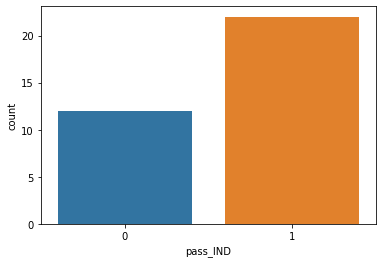

In [242]:
sns.countplot(x='pass_IND', data=df_clean);

In [245]:
grades = df_clean.iloc[:, 43:48]

In [247]:
cor_matrix = grades.corr()
cor_matrix.style.background_gradient(cmap='viridis_r')

,Session 2,Session 3,Session 4,Session 5,Session 6
Session 2,1,0.662718,0.42483,0.49168,0.359912
Session 3,0.662718,1,0.439425,0.439928,0.333721
Session 4,0.42483,0.439425,1,0.379807,0.482203
Session 5,0.49168,0.439928,0.379807,1,0.0594774
Session 6,0.359912,0.333721,0.482203,0.0594774,1


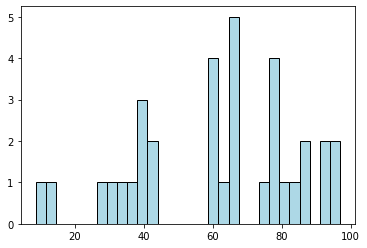

In [248]:
plt.hist(df['total'], color='lightblue', edgecolor='black', bins=30);

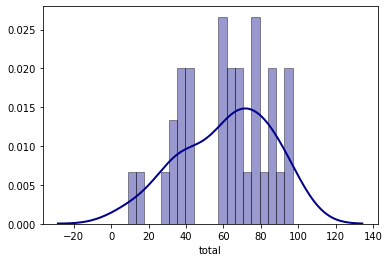

In [249]:
sns.distplot(df.total, hist=True, kde=True,
            bins=20, color='darkblue',
            hist_kws={'edgecolor':'black'},
            kde_kws={'linewidth': 2});

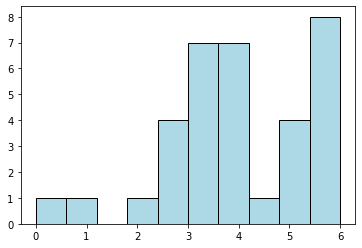

In [251]:
plt.hist(grades['Session 2'], color='lightblue', edgecolor='black');

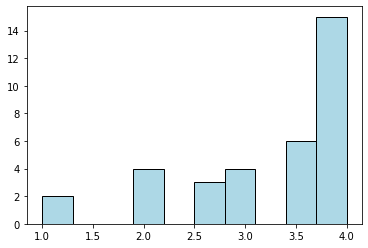

In [252]:
plt.hist(grades['Session 3'], color='lightblue', edgecolor='black');

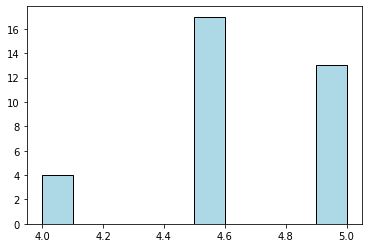

In [254]:
plt.hist(grades['Session 4'], color='lightblue', edgecolor='black');

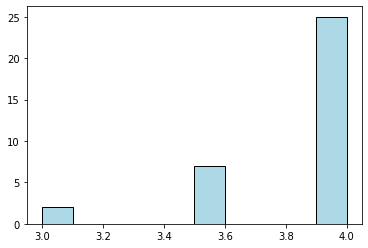

In [255]:
plt.hist(grades['Session 5'], color='lightblue', edgecolor='black');

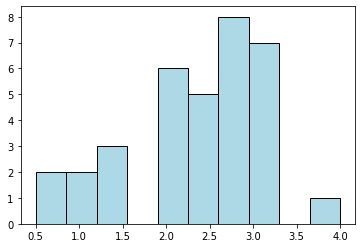

In [258]:
plt.hist(grades['Session 6'], color='lightblue', edgecolor='black');

From the histograms of these intermediate grades, we can see that the grades are clustered to several groups in session 3, 4, and 5, just as the author of the dataset said, students can work together or just copy each others assignments, thus, intermediate grades are not reliable.

# Classification

## Data Separation

In [262]:
df_clean.iloc[:, 1:43].head()

,work_time1,work_time2,work_time3,work_time4,work_time5,work_time6,mouse_wheel1,mouse_wheel2,mouse_wheel3,mouse_wheel4,mouse_wheel5,mouse_wheel6,mouse_wheel_click1,mouse_wheel_click2,mouse_wheel_click3,mouse_wheel_click4,mouse_wheel_click5,mouse_wheel_click6,mouse_click_left1,mouse_click_left2,mouse_click_left3,mouse_click_left4,mouse_click_left5,mouse_click_left6,mouse_click_right1,mouse_click_right2,mouse_click_right3,mouse_click_right4,mouse_click_right5,mouse_click_right6,mouse_movement1,mouse_movement2,mouse_movement3,mouse_movement4,mouse_movement5,mouse_movement6,keystroke1,keystroke2,keystroke3,keystroke4,keystroke5,keystroke6
0,4215.0,8500.0,9741.0,4095.0,5128.0,5706.0,0.0,0.0,1379.0,826.0,1570.0,708.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3696.0,5543.0,1857.0,2211.0,2812.0,0.0,98.0,304.0,82.0,164.0,104.0,45.0,69226.0,259130.0,91633.0,122581.0,165494.0,1047.0,5151.0,4873.0,2232.0,3142.0,1140.0
1,4071.0,7754.0,8489.0,3252.0,5037.0,9027.0,586.0,1538.0,2069.0,489.0,1138.0,904.0,0.0,0.0,0.0,0.0,0.0,0.0,1977.0,4303.0,2703.0,1419.0,1924.0,4857.0,10.0,65.0,117.0,74.0,130.0,114.0,207317.0,317737.0,273721.0,119589.0,198103.0,427595.0,1207.0,5450.0,7433.0,2369.0,2701.0,1552.0
2,5086.0,7975.0,9421.0,4893.0,3465.0,8999.0,0.0,2145.0,728.0,342.0,1088.0,968.0,18.0,0.0,0.0,0.0,2.0,0.0,2238.0,2733.0,3761.0,1068.0,1088.0,3533.0,64.0,168.0,390.0,34.0,82.0,96.0,107269.0,207043.0,156059.0,61183.0,84820.0,241519.0,1745.0,3873.0,5159.0,3270.0,3491.0,727.0
3,4660.0,7736.0,8413.0,4976.0,5269.0,8151.0,573.0,1305.0,517.0,957.0,2577.0,1131.0,0.0,0.0,4.0,0.0,0.0,0.0,2244.0,3830.0,4709.0,5112.0,3855.0,4846.0,171.0,320.0,358.0,48.0,146.0,86.0,145381.0,226786.0,262458.0,183880.0,175403.0,246180.0,653.0,4299.0,2982.0,2394.0,2744.0,980.0
4,4908.0,8785.0,9968.0,2459.0,3959.0,9095.0,312.0,1153.0,153.0,539.0,888.0,493.0,0.0,0.0,0.0,0.0,0.0,0.0,2446.0,2987.0,323.0,1429.0,1826.0,4583.0,149.0,274.0,2.0,15.0,132.0,62.0,219138.0,302207.0,26362.0,125858.0,195455.0,381456.0,458.0,3534.0,2609.0,2138.0,1887.0,1084.0


In [592]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
X = preprocessing.scale(df_clean.iloc[:, 1:43].values)
X_features = df_clean.iloc[:, 1:43].columns
y = df_clean.iloc[:, 48].values


# Split dataset into training set and test set
# 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=111) 

In [593]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (25, 42)
y_train shape: (25,)
X_test shape: (9, 42)
y_test shape: (9,)


In [594]:
y_test

array([1, 1, 0, 0, 0, 1, 1, 1, 1])

## K Nearest Neighbors

Start KNN classifier with 1 neighbor:

In [595]:
from sklearn.neighbors import KNeighborsClassifier
# start trying with neighbors = 1
knn = KNeighborsClassifier(n_neighbors=1)

Fit the model:

In [596]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

Make prediction:

In [597]:
# making predictions
y_pred = knn.predict(X_test)

Check accuracy:

In [598]:
np.mean(y_pred == y_test)

0.6666666666666666

Try with 3 neighbors:

In [599]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
np.mean(y_pred == y_test)

0.5555555555555556

Try with 5 neighbors:

In [600]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
np.mean(y_pred == y_test)

0.7777777777777778

Try with 1 to 15 neighbors:

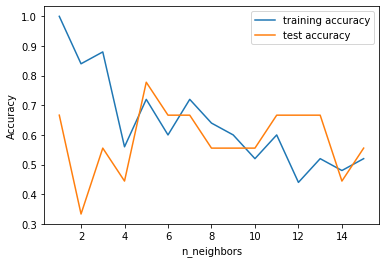

In [601]:
train_acc = []
test_acc = []
neighbors_set = range(1, 16)

for n_neighbors in neighbors_set:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    train_acc.append(clf.score(X_train, y_train))
    test_acc.append(clf.score(X_test, y_test))

plt.plot(neighbors_set, train_acc, label="training accuracy")
plt.plot(neighbors_set, test_acc, label="test accuracy")
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy")
plt.legend();

In [602]:
max(test_acc)

0.7777777777777778

Grid search with cross validation for best number of neighbors:

In [603]:
knn_param_grid = dict(n_neighbors=range(1, 16))
knn = KNeighborsClassifier()

In [604]:
knn_grid = GridSearchCV(knn, knn_param_grid, cv=5, verbose=0, iid=True)

In [605]:
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid=True, n_jobs=None, param_grid={'n_neighbors': range(1, 16)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [606]:
knn_grid.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [607]:
knn_grid_pred = knn_grid.predict(X_test)

In [608]:
print(confusion_matrix(y_test, knn_grid_pred))
print('\n')
print(classification_report(y_test, knn_grid_pred))

[[1 2]
 [2 4]]


              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.67      0.67      0.67         6

    accuracy                           0.56         9
   macro avg       0.50      0.50      0.50         9
weighted avg       0.56      0.56      0.56         9



## Support Vector Machine

Start with default SVM settings:

In [609]:
from sklearn.svm import SVC
svc = SVC(gamma='scale', random_state=1115)

In [610]:
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=1115, shrinking=True,
    tol=0.001, verbose=False)

In [611]:
y_pred = svc.predict(X_test)

In [612]:
from sklearn.metrics import classification_report, confusion_matrix

In [613]:
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

[[0 3]
 [1 5]]


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.62      0.83      0.71         6

    accuracy                           0.56         9
   macro avg       0.31      0.42      0.36         9
weighted avg       0.42      0.56      0.48         9



Try to search with best parameter with grid search:

In [614]:
from sklearn.model_selection import GridSearchCV

In [615]:
svm_param_grid = {'C':[0.1, 1, 10, 100, 1000], 'gamma':[1, 0.1, 0.01, 0.001, 0.0001], 
                  'kernel':["linear", "poly", "rbf", "sigmoid"]}

In [616]:
svm_grid = GridSearchCV(SVC(random_state=1115), svm_param_grid, cv=5, verbose=0, iid=False)

In [617]:
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=1115, shrinking=True,
                           tol=0.001, verbose=False),
             iid=False, n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [618]:
svm_grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [619]:
svm_grid.best_estimator_

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=1115, shrinking=True,
    tol=0.001, verbose=False)

In [620]:
svm_grid_pred = svm_grid.predict(X_test)

In [621]:
print(confusion_matrix(y_test, svm_grid_pred))
print('\n')
print(classification_report(y_test, svm_grid_pred))

[[0 3]
 [1 5]]


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.62      0.83      0.71         6

    accuracy                           0.56         9
   macro avg       0.31      0.42      0.36         9
weighted avg       0.42      0.56      0.48         9



## Logistic Regression

Start with default settings:

In [622]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=1115, solver='lbfgs')

In [623]:
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1115, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [624]:
logr_pred = logreg.predict(X_test)

In [625]:
print(confusion_matrix(y_test, logr_pred))
print('\n')
print(classification_report(y_test, logr_pred))

[[1 2]
 [2 4]]


              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.67      0.67      0.67         6

    accuracy                           0.56         9
   macro avg       0.50      0.50      0.50         9
weighted avg       0.56      0.56      0.56         9



Try with different C values and penalty types:

In [626]:
C = np.logspace(0, 3, 10)

logr_param_grid = dict(C=C)
logr_grid = GridSearchCV(LogisticRegression(random_state=1115, solver='lbfgs'), logr_param_grid, 
                    cv=5, iid=False, verbose=0)

In [627]:
logr_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=1115, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid=False, n_jobs=None,
             param_grid={'C': array([   1.        ,    2.15443469,    4.64158883,   10.        ,
         21.5443469 ,   46.41588834,  100.        ,  215.443469  ,
        464.15888336, 1000.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [628]:
logr_grid.best_params_

{'C': 1.0}

In [629]:
logr_grid.best_estimator_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1115, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [630]:
logr_grid_pred = logr_grid.predict(X_test)

In [631]:
print(confusion_matrix(y_test, logr_grid_pred))
print('\n')
print(classification_report(y_test, logr_grid_pred))

[[1 2]
 [2 4]]


              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.67      0.67      0.67         6

    accuracy                           0.56         9
   macro avg       0.50      0.50      0.50         9
weighted avg       0.56      0.56      0.56         9



## Decision Tree

Start from default settings:

In [632]:
from sklearn.tree import DecisionTreeClassifier

In [633]:
dtree = DecisionTreeClassifier(random_state=1115)

In [634]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1115, splitter='best')

In [635]:
y_pred = dtree.predict(X_test)

In [636]:
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

[[0 3]
 [1 5]]


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.62      0.83      0.71         6

    accuracy                           0.56         9
   macro avg       0.31      0.42      0.36         9
weighted avg       0.42      0.56      0.48         9



Try with different parameters:

In [637]:
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [638]:
dtree = DecisionTreeClassifier(random_state=1115)

In [639]:
criterion = ['gini', 'entropy']
max_depth = [2, 4, 6, 8, 10, 12]

In [640]:
dtree_param_grid = dict(criterion=criterion,
                        max_depth=max_depth)

In [641]:
dtree_grid = GridSearchCV(dtree, dtree_param_grid, cv=5, verbose=0, iid=False)

In [642]:
dtree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=1115,
                                              splitter='best'),
             iid=False, n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12]},
             pre_

In [643]:
dtree_grid.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1115, splitter='best')

In [644]:
dtree_grid_pred = dtree_grid.predict(X_test)

In [645]:
print(confusion_matrix(y_test, dtree_grid_pred))
print('\n')
print(classification_report(y_test, dtree_grid_pred))

[[0 3]
 [1 5]]


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.62      0.83      0.71         6

    accuracy                           0.56         9
   macro avg       0.31      0.42      0.36         9
weighted avg       0.42      0.56      0.48         9



## Random Forest

In [646]:
from sklearn.ensemble import RandomForestClassifier

In [647]:
rfc = RandomForestClassifier(n_estimators=100, random_state=1115)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1115,
                       verbose=0, warm_start=False)

In [648]:
y_pred = rfc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

[[0 3]
 [1 5]]


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.62      0.83      0.71         6

    accuracy                           0.56         9
   macro avg       0.31      0.42      0.36         9
weighted avg       0.42      0.56      0.48         9



We can try to adjust some of the hyper-parameters:

In [649]:
rfc = RandomForestClassifier(random_state=1115)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=100, stop=500, num=5)]

In [650]:
rfc_param_grid = {'n_estimators': n_estimators}

In [651]:
rfc_grid = GridSearchCV(rfc, rfc_param_grid, cv=5, verbose=0, iid=False)

In [652]:
rfc_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=1115, verbose=0,
                                              warm_start=False),
             iid

In [653]:
rfc_grid.best_params_

{'n_estimators': 300}

In [654]:
rfc_grid_pred = rfc_grid.predict(X_test)

In [655]:
print(confusion_matrix(y_test, rfc_grid_pred))
print('\n')
print(classification_report(y_test, rfc_grid_pred))

[[0 3]
 [1 5]]


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.62      0.83      0.71         6

    accuracy                           0.56         9
   macro avg       0.31      0.42      0.36         9
weighted avg       0.42      0.56      0.48         9



## XGBoost

Start with default setting:

In [656]:
from xgboost import XGBClassifier

In [657]:
xgb = XGBClassifier(random_state=1115)

In [658]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1115,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [659]:
y_pred = xgb.predict(X_test)

In [660]:
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

[[1 2]
 [2 4]]


              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.67      0.67      0.67         6

    accuracy                           0.56         9
   macro avg       0.50      0.50      0.50         9
weighted avg       0.56      0.56      0.56         9



Try with a smaller learning rate:

In [661]:
xgb = XGBClassifier(learning_rate=0.01, random_state=1115)

In [662]:
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

[[0 3]
 [2 4]]


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.57      0.67      0.62         6

    accuracy                           0.44         9
   macro avg       0.29      0.33      0.31         9
weighted avg       0.38      0.44      0.41         9



Grid Search for best-generalized parameters:

In [663]:
xgb_param_grid = {'learning_rate': [0.1, 0.01, 0.001, 0.0001], 'n_estimators': [50, 100, 200, 300]}
xgb = XGBClassifier(random_state=1115)

Grid search with k-fold cross validation:

In [664]:
xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=5, verbose=0, iid=True)

In [665]:
xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=1115, reg_alpha=0,
                                     reg_lambda=1, scale_pos_weight=1,
                                     seed=None, silent=None, subsample=1,
                                     verbosity=1),
             iid=True, n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.01, 0.001, 0.0001],
                         'n_estimators': [50, 100, 200, 300

In [666]:
xgb_grid_pred = xgb_grid.predict(X_test)

In [667]:
print(confusion_matrix(y_test, xgb_grid_pred))
print('\n')
print(classification_report(y_test, xgb_grid_pred))

[[0 3]
 [2 4]]


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.57      0.67      0.62         6

    accuracy                           0.44         9
   macro avg       0.29      0.33      0.31         9
weighted avg       0.38      0.44      0.41         9



# Clustering

We use K-means clustering method to cluster the students based on their behavior data:

In [668]:
from sklearn.cluster import KMeans

In [673]:
km = KMeans(n_clusters=5, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=1115)

In [674]:
y_km = km.fit_predict(X)

In [675]:
y_km

array([4, 1, 4, 2, 1, 4, 3, 4, 1, 4, 4, 4, 4, 2, 0, 2, 4, 3, 3, 3, 1, 2,
       4, 1, 4, 3, 2, 2, 4, 3, 4, 1, 3, 3], dtype=int32)

In [677]:
df_clean['cluster'] = y_km

In [678]:
df_clean.head()

,student_Id,work_time1,work_time2,work_time3,work_time4,work_time5,work_time6,mouse_wheel1,mouse_wheel2,mouse_wheel3,mouse_wheel4,mouse_wheel5,mouse_wheel6,mouse_wheel_click1,mouse_wheel_click2,mouse_wheel_click3,mouse_wheel_click4,mouse_wheel_click5,mouse_wheel_click6,mouse_click_left1,mouse_click_left2,mouse_click_left3,mouse_click_left4,mouse_click_left5,mouse_click_left6,mouse_click_right1,mouse_click_right2,mouse_click_right3,mouse_click_right4,mouse_click_right5,mouse_click_right6,mouse_movement1,mouse_movement2,mouse_movement3,mouse_movement4,mouse_movement5,mouse_movement6,keystroke1,keystroke2,keystroke3,keystroke4,keystroke5,keystroke6,Session 2,Session 3,Session 4,Session 5,Session 6,pass_IND,cluster
0,2,4215.0,8500.0,9741.0,4095.0,5128.0,5706.0,0.0,0.0,1379.0,826.0,1570.0,708.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3696.0,5543.0,1857.0,2211.0,2812.0,0.0,98.0,304.0,82.0,164.0,104.0,45.0,69226.0,259130.0,91633.0,122581.0,165494.0,1047.0,5151.0,4873.0,2232.0,3142.0,1140.0,4.0,3.5,4.5,4.0,1.00,0,4
1,5,4071.0,7754.0,8489.0,3252.0,5037.0,9027.0,586.0,1538.0,2069.0,489.0,1138.0,904.0,0.0,0.0,0.0,0.0,0.0,0.0,1977.0,4303.0,2703.0,1419.0,1924.0,4857.0,10.0,65.0,117.0,74.0,130.0,114.0,207317.0,317737.0,273721.0,119589.0,198103.0,427595.0,1207.0,5450.0,7433.0,2369.0,2701.0,1552.0,5.0,4.0,5.0,4.0,2.75,0,1
2,7,5086.0,7975.0,9421.0,4893.0,3465.0,8999.0,0.0,2145.0,728.0,342.0,1088.0,968.0,18.0,0.0,0.0,0.0,2.0,0.0,2238.0,2733.0,3761.0,1068.0,1088.0,3533.0,64.0,168.0,390.0,34.0,82.0,96.0,107269.0,207043.0,156059.0,61183.0,84820.0,241519.0,1745.0,3873.0,5159.0,3270.0,3491.0,727.0,4.0,4.0,4.5,4.0,2.00,1,4
3,10,4660.0,7736.0,8413.0,4976.0,5269.0,8151.0,573.0,1305.0,517.0,957.0,2577.0,1131.0,0.0,0.0,4.0,0.0,0.0,0.0,2244.0,3830.0,4709.0,5112.0,3855.0,4846.0,171.0,320.0,358.0,48.0,146.0,86.0,145381.0,226786.0,262458.0,183880.0,175403.0,246180.0,653.0,4299.0,2982.0,2394.0,2744.0,980.0,5.0,4.0,4.5,4.0,3.00,0,2
4,11,4908.0,8785.0,9968.0,2459.0,3959.0,9095.0,312.0,1153.0,153.0,539.0,888.0,493.0,0.0,0.0,0.0,0.0,0.0,0.0,2446.0,2987.0,323.0,1429.0,1826.0,4583.0,149.0,274.0,2.0,15.0,132.0,62.0,219138.0,302207.0,26362.0,125858.0,195455.0,381456.0,458.0,3534.0,2609.0,2138.0,1887.0,1084.0,4.0,2.0,5.0,4.0,1.50,1,1


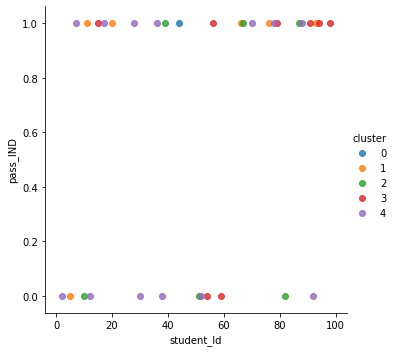

In [680]:

sns.lmplot(data=df_clean, x='student_Id', y='pass_IND', hue='cluster', fit_reg=False, legend=True, legend_out=True);

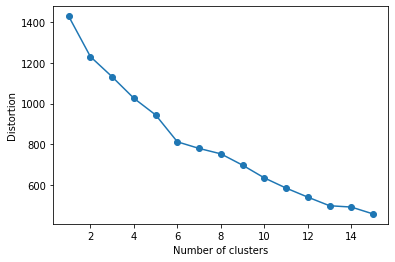

In [681]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 16):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 16), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

# Conclusions